# Potato Disease Classification

### Importing necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

#### Set all the Constants

In [2]:
# Creating variables for later use.
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS =50

#### Import data into tensorflow dataset object

In [3]:
# Importing data from the disk, shuffle it then giving the size and batch size of images 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names # To check the number of classes.

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset) # why so?? It is because we have converted it into batches of size 32.

68

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 2 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0]


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    print(image_batch.shape)

[[[126. 115. 123.]
  [130. 119. 127.]
  [137. 126. 134.]
  ...
  [174. 164. 172.]
  [177. 167. 175.]
  [180. 170. 178.]]

 [[128. 117. 125.]
  [131. 120. 128.]
  [135. 124. 132.]
  ...
  [176. 166. 174.]
  [179. 169. 177.]
  [181. 171. 179.]]

 [[136. 125. 133.]
  [137. 126. 134.]
  [137. 126. 134.]
  ...
  [179. 169. 177.]
  [181. 171. 179.]
  [183. 173. 181.]]

 ...

 [[126. 116. 127.]
  [130. 120. 131.]
  [129. 119. 130.]
  ...
  [154. 148. 162.]
  [155. 149. 163.]
  [158. 152. 166.]]

 [[131. 121. 132.]
  [132. 122. 133.]
  [128. 118. 129.]
  ...
  [154. 148. 162.]
  [158. 152. 166.]
  [162. 156. 170.]]

 [[132. 122. 133.]
  [130. 120. 131.]
  [126. 116. 127.]
  ...
  [151. 145. 159.]
  [158. 152. 166.]
  [164. 158. 172.]]]
(32, 256, 256, 3)


#### Visualize some of the images from our dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


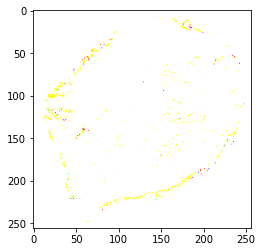

In [9]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy())
# The image is appering like this becuase it is a float in nature so we have to convert it into int.

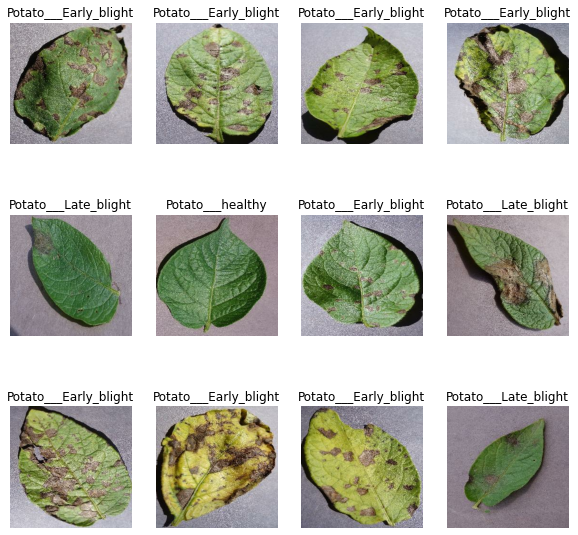

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1) # This is a matrix so that we can display multiple images.
        plt.imshow(image_batch[i].numpy().astype("uint8")) # This is a solution of above problem.
        plt.axis("off") 
        plt.title(class_names[label_batch[i]]) # Displaying labels

### Splitting Our Dataset
Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [11]:
# 80% ==> training
# 20% ==> 10% validation 10% testing

In [12]:
train_size = 0.8  # This is a way to initialize the 80% of training dataset. 
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54) # That's how you split the training dataset in tensorflow.

In [14]:
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54) # It will skip first 54 training dataset.
len(test_ds)

14

In [16]:
val_size = .1 # This is my validation size. Which is used for validate the output after every epochs.
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(test_ds)

8

In [23]:
len(val_ds)

6

#### Cache, Shuffle, and Prefetch the Dataset

In [24]:
# This all is done to improve the speed of fetching the data and training the model.

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

##### Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.


In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Building the Model

#### Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

##### We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [29]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

#### Compiling the Model


We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 265s 5s/step - loss: 0.9073 - accuracy: 0.5405 - val_loss: 0.8184 - val_accuracy: 0.6146
Epoch 2/50
54/54 [==============================] - 318s 6s/step - loss: 0.6323 - accuracy: 0.7141 - val_loss: 0.4875 - val_accuracy: 0.7812
Epoch 3/50
54/54 [==============================] - 378s 7s/step - loss: 0.4419 - accuracy: 0.8056 - val_loss: 0.3610 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 314s 6s/step - loss: 0.3103 - accuracy: 0.8727 - val_loss: 0.2337 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 250s 5s/step - loss: 0.2562 - accuracy: 0.8895 - val_loss: 0.1907 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 414s 8s/step - loss: 0.2545 - accuracy: 0.9016 - val_loss: 0.2888 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 163s 3s/step - loss: 0.1996 - accuracy: 0.9242 - val_loss: 0.1769 - val_accuracy: 0.9323
Epoch 8/50
54

In [33]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 15s 1s/step - loss: 0.1042 - accuracy: 0.9609


#### You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [34]:
scores

[0.1041630208492279, 0.9609375]

#### Plotting the Accuracy and Loss Curves

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [38]:
type(history.history['loss'])

list

In [39]:
len(history.history['loss'])

50

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

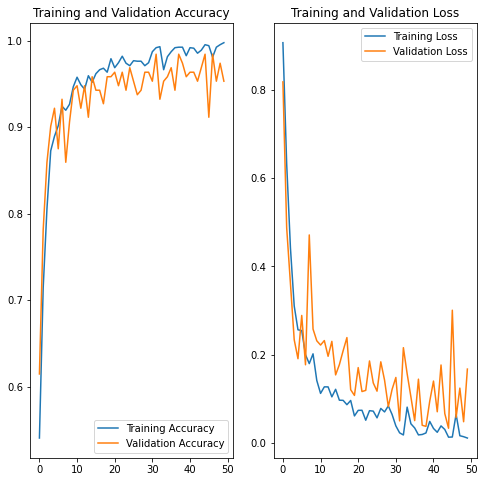

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Late_blight


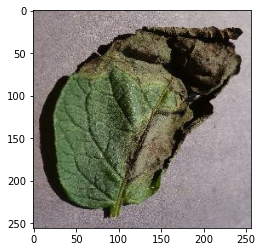

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#### Write a function for inference


In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 143ms/step


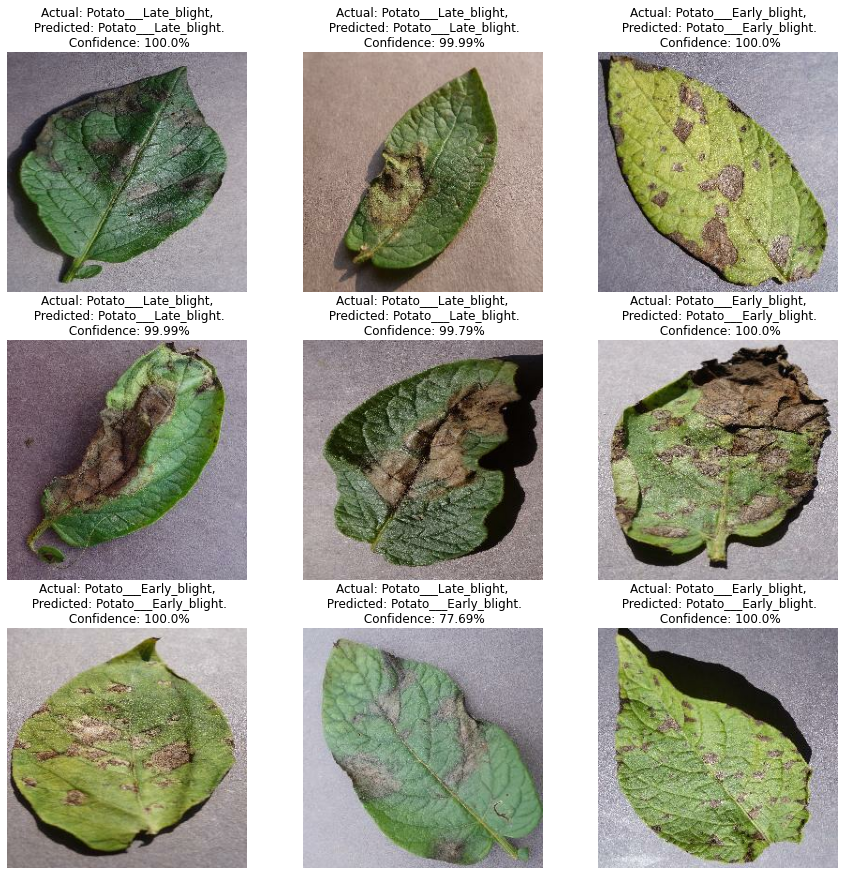

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Saving the Model
We append the model to the list of models as a new version

In [47]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'

In [49]:
model.save("../potatoes.h5")

In [48]:
model_version =1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
